# Task 2. Problem-solving


## Project plan
- [ 1. Data loading and preparation ](#section1)
- [ 2. Highlight user cohorts based on the week of registration in the application. The cohort ](#section2) 
- [ 3. How many unique users in the cohort with ID 33? ](#section3) 
- [ 4. For each event, highlight the indicator lifetime - the weekly lifetime of the cohort. ](#section4)   
- [ 5. Build a summary table of changes in the Retention Rate for cohorts depending on lifetime. ](#section5)     
- [ 6. What is the 3 week retention rate for a cohort with ID 32?](#section6)
- [ 7. Build a summary table of changes in the indicator ARPPU for cohorts depending on lifetime.
](#section7)
- [ 8. What is the 3-week ARPPU of a cohort with ID 31?](#section8)
- [ 9. What is the median time between user registration and first purchase?](#section9)

<a id='section1'></a>
#### 1. Data loading and preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('event_data.csv')

df['event_date'] = pd.to_datetime(df['event_date'])

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79742 entries, 0 to 79741
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   user_id          79742 non-null  object        
 1   event_date       79742 non-null  datetime64[ns]
 2   event_type       79742 non-null  object        
 3   purchase_amount  6207 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.4+ MB
None


,user_id,event_date,event_type,purchase_amount
0,c40e6a,2019-07-29 00:02:15,registration,NaN
1,a2b682,2019-07-29 00:04:46,registration,NaN
2,9ac888,2019-07-29 00:13:22,registration,NaN
3,93ff22,2019-07-29 00:16:47,registration,NaN
4,65ef85,2019-07-29 00:19:23,registration,NaN


<a id='section2'></a>
#### 2. Highlight user cohorts based on the week of registration in the application. The cohort identifier should be the week ordinal (for example, the week from July 29 to August 4 should have identifier 31).

In [2]:
df_with_week = df.query('event_type=="registration"').groupby('user_id').agg({'event_date':'min'})['event_date'].dt.isocalendar().week
df = df.merge(df_with_week, left_on='user_id', right_on=df_with_week.index)

df.rename(columns={'week':'week_of_registration'}, inplace=True)
df['week_of_registration'] = df['week_of_registration'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79742 entries, 0 to 79741
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               79742 non-null  object        
 1   event_date            79742 non-null  datetime64[ns]
 2   event_type            79742 non-null  object        
 3   purchase_amount       6207 non-null   float64       
 4   week_of_registration  79742 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 3.3+ MB


<a id='section3'></a>
#### 3. How many unique users in the cohort with ID 33?

In [3]:
print("There are {} unique users in 33's cohort".format(df.query('week_of_registration==33')['user_id'].nunique()) )

There are 2045 unique users in 33's cohort


<a id='section4'></a>
#### 4. For each event, highlight the indicator lifetime - the weekly lifetime of the cohort. The lifetime indicator is calculated based on the serial number of the week in which the event is committed, relative to the week of registration. For example, an event committed on August 3 by a user from a cohort of registrants at 31 weeks will be committed on the zero week of lifetime, and an event committed by the same user on August 5 will be committed on the first week of lifetime).

In [4]:
df['lifetime'] = df['event_date'].dt.isocalendar().week - df['week_of_registration']
df['lifetime'] = df['lifetime'].astype('int')

df.query('lifetime!=0')

,user_id,event_date,event_type,purchase_amount,week_of_registration,lifetime
5,c40e6a,2019-08-05 07:09:40,simple_event,NaN,31,1
6,c40e6a,2019-08-08 02:48:27,simple_event,NaN,31,1
7,c40e6a,2019-08-10 11:40:06,purchase,10.0,31,1
8,c40e6a,2019-08-11 11:03:15,simple_event,NaN,31,1
9,c40e6a,2019-08-13 04:14:49,simple_event,NaN,31,2
...,...,...,...,...,...,...
73679,29dc09,2019-08-27 09:14:47,simple_event,NaN,34,1
73680,29dc09,2019-08-28 13:24:53,simple_event,NaN,34,1
73681,29dc09,2019-08-31 05:25:44,simple_event,NaN,34,1
73682,29dc09,2019-08-31 21:19:18,simple_event,NaN,34,1


<a id='section5'></a>
#### 5. Build a summary table of changes in the Retention Rate for cohorts depending on lifetime.

lifetime                0         1         2         3        4
week_of_registration                                            
31                    1.0  0.927595  0.629367  0.356962  0.15038
32                    1.0  0.929303  0.648053  0.361168      NaN
33                    1.0  0.924205  0.661125       NaN      NaN
34                    1.0  0.929078       NaN       NaN      NaN
35                    1.0       NaN       NaN       NaN      NaN


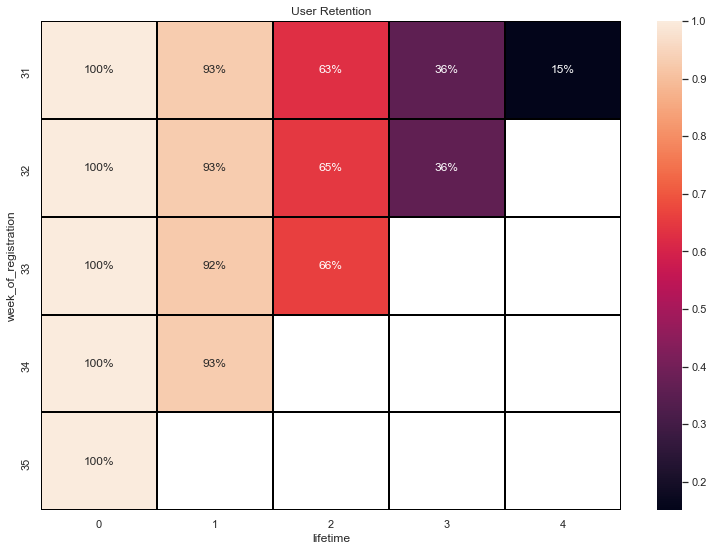

In [5]:
cohorts = df.groupby(['week_of_registration', 'lifetime']).agg({'user_id':'nunique'}).reset_index()

initial_users_count = cohorts[cohorts['lifetime'] == 0][
    ['week_of_registration', 'user_id']
]

initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'})

cohorts = cohorts.merge(initial_users_count,on='week_of_registration') 

cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

retention_pivot = cohorts.pivot_table(
    index='week_of_registration',
    columns='lifetime',
    values='retention',
    aggfunc='sum',
) 

print(retention_pivot)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.0%', linewidths=1, linecolor='black'); 

<a id='section6'></a>
#### 6. What is the 3 week retention rate for a cohort with ID 32? Give the answer in percent, rounded to 2 decimal places, inclusive.

In [6]:
print("The retention rate for 32's cohort of the third week is {}".format(round(retention_pivot.loc[(32, 3)]*100,2), '%.2f'))


The retention rate for 32's cohort of the third week is 36.12


<a id='section7'></a>
#### 7. Build a summary table of changes in the indicator ARPPU (Average Revenue Per Paying User) for cohorts depending on lifetime.

lifetime                      0          1          2          3          4
week_of_registration                                                       
31                    28.132911  29.511494  30.525000  29.142857  30.454545
32                    30.222841  29.773692  29.928741  29.528302        NaN
33                    30.689655  30.519663  29.171975        NaN        NaN
34                    30.776699  30.929134        NaN        NaN        NaN
35                    30.721925        NaN        NaN        NaN        NaN


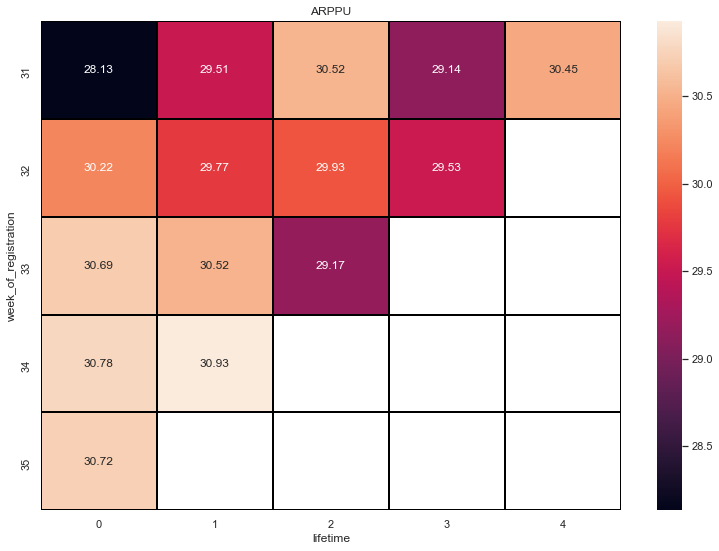

In [7]:
cohorts = df.query("event_type=='purchase'").groupby(['week_of_registration', 'lifetime']).agg({'purchase_amount':'mean'}).reset_index()

#cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 

arppu_pivot = cohorts.pivot_table(
    index='week_of_registration',
    columns='lifetime',
    values='purchase_amount',
    aggfunc='sum',
) 

print(arppu_pivot)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ARPPU')
sns.heatmap(arppu_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black'); 
plt.show()

<a id='section8'></a>
#### 8. What is the 3-week ARPPU of a cohort with ID 31? Give the answer with a floating point number, rounded to 2 decimal places, inclusive.

In [8]:
print("The ARPPU rate for 31's cohort of the third week is {}".format(round(arppu_pivot.loc[(31, 3)],2), '.2f'))

The ARPPU rate for 31's cohort of the third week is 29.14


<a id='section9'></a>
#### 9. What is the median time between user registration and first purchase? Give the answer in seconds (!) As an integer.

In [9]:
df_with_registration = df.query('event_type=="registration"').groupby('user_id').agg({'event_date':'min'}).reset_index()
df_with_registration = df_with_registration.rename(columns={'event_date':'first_registration'})

df_with_purchase = df.query('event_type=="purchase"').groupby('user_id').agg({'event_date':'min'}).reset_index()
df_with_purchase = df_with_purchase.rename(columns={'event_date':'first_purchase'})

df_with_registration = df_with_registration.merge(df_with_purchase, left_on='user_id', right_on='user_id')

int((df_with_registration['first_purchase']-df_with_registration['first_registration']).dt.seconds.median())

43623